In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import models
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, ConvLSTM2D, MultiHeadAttention, Flatten, MaxPooling3D, BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DIR = "drive/MyDrive/dataset"

In [ ]:
# cek
os.listdir(DIR)

['train', 'val']

In [ ]:
print("file train/fight: ",len(os.listdir(DIR+"/train/Fight")))
print("file train/nonfight:", len(os.listdir(DIR+"/train/NonFight")))
print("file val/fight: ", len(os.listdir(DIR+"/val/Fight")))
print("file val/nonfight: ", len(os.listdir(DIR+"/val/NonFight")))

file train/fight:  800
file train/nonfight: 800
file val/fight:  200
file val/nonfight:  200


In [ ]:
class FrameGenerator:
    def __init__(self, path, training=False):
        """ Returns a set of frames with their associated label.
          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path

        self.training = training
        self.class_names = ['NonFight', 'Fight']
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        if self.training:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        else:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        classes = [p.parent.name for p in video_paths]

        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = self.read_npy_file(path)
            label = self.class_ids_for_name[name]
            yield video_frames, label


    def read_npy_file(self, path):
        data = np.load(path)
        data = np.float32(data)
        data = data/255.0
        return data

In [ ]:
train_file = Path(DIR).joinpath("train").with_suffix('')
test_file = Path(DIR).joinpath("val").with_suffix('')
train_file

PosixPath('drive/MyDrive/dataset/train')

In [ ]:
fg = FrameGenerator(train_file, training=True)

# test
frames, label = next(fg())
print(fg)
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (21, 224, 224, 3)
Label: 0


In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=3)
  return embed.embed_file('./animation.gif')


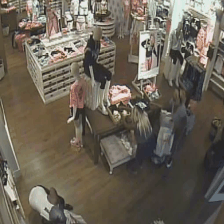

In [ ]:
to_gif(frames)

In [ ]:
# buat tf.data.Dataset
batch_size = 8

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_file, training=True),
                                          output_signature=output_signature)


test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_file),
                                          output_signature=output_signature)


In [ ]:
train_ds = train_ds.shuffle(buffer_size=1000)
test_ds = test_ds.shuffle(buffer_size=1000)

In [ ]:
def count_dataset(dataset):
    return sum(1 for _ in dataset)

num_train_ds = count_dataset(train_ds)
num_test_ds = count_dataset(test_ds)

print(num_train_ds)
print(num_test_ds)

1600
400


In [ ]:
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# test data
for frames, labels in train_ds.take(10):
    print(labels)

print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

tf.Tensor([0 0 0 1 0 1 0 1], shape=(8,), dtype=int16)
tf.Tensor([0 0 0 0 0 0 0 0], shape=(8,), dtype=int16)
tf.Tensor([0 1 1 0 0 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([1 0 0 0 1 1 1 0], shape=(8,), dtype=int16)
tf.Tensor([0 1 0 0 0 1 1 0], shape=(8,), dtype=int16)
tf.Tensor([1 1 0 0 1 1 0 1], shape=(8,), dtype=int16)
tf.Tensor([1 1 1 0 1 0 0 0], shape=(8,), dtype=int16)
tf.Tensor([0 0 0 1 0 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([0 1 1 1 1 0 1 1], shape=(8,), dtype=int16)
tf.Tensor([1 0 1 0 1 0 0 1], shape=(8,), dtype=int16)
Shape: (8, 21, 224, 224, 3)
Label: (8,)


In [ ]:
def plot_history(history):



  # Plot training & validation accuracy values
  plt.figure(figsize=(14, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.show()

# **21 frame**

In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg',
                                                  weights='imagenet')

In [ ]:
# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (21, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 21, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_3 (TimeDi  (None, 21, 7, 7, 2048)       2358771   ['input_7[0][0]']             
 stributed)                                               2                                       
                                                                                                  
 conv_lstm2d_6 (ConvLSTM2D)  (None, 21, 7, 7, 256)        2123468   ['time_distributed_3[0][0]']  
                                                          8                                       
                                                                                            

In [ ]:
epochs = 10
lr = 1e-6

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/10
200/200 [==============================] - 153s 558ms/step - loss: 0.6887 - accuracy: 0.5537 - val_loss: 0.6928 - val_accuracy: 0.5150
Epoch 2/10
200/200 [==============================] - 104s 519ms/step - loss: 0.6606 - accuracy: 0.6750 - val_loss: 0.6469 - val_accuracy: 0.7125
Epoch 3/10
200/200 [==============================] - 104s 518ms/step - loss: 0.5918 - accuracy: 0.7269 - val_loss: 0.5481 - val_accuracy: 0.7725
Epoch 4/10
200/200 [==============================] - 104s 519ms/step - loss: 0.5048 - accuracy: 0.7681 - val_loss: 0.5043 - val_accuracy: 0.7675
Epoch 5/10
200/200 [==============================] - 105s 523ms/step - loss: 0.4175 - accuracy: 0.8181 - val_loss: 0.4987 - val_accuracy: 0.7675
Epoch 6/10
200/200 [==============================] - 104s 519ms/step - loss: 0.3191 - accuracy: 0.8706 - val_loss: 0.5207 - val_accuracy: 0.7525
Epoch 7/10
200/200 [==============================] - 104s 519ms/step - loss: 0.2104 - accuracy: 0.9331 - val_loss: 0.5816 -

In [ ]:
model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 8s 156ms/step - loss: 1.0346 - accuracy: 0.7150


{'loss': 1.0345547199249268, 'accuracy': 0.7149999737739563}

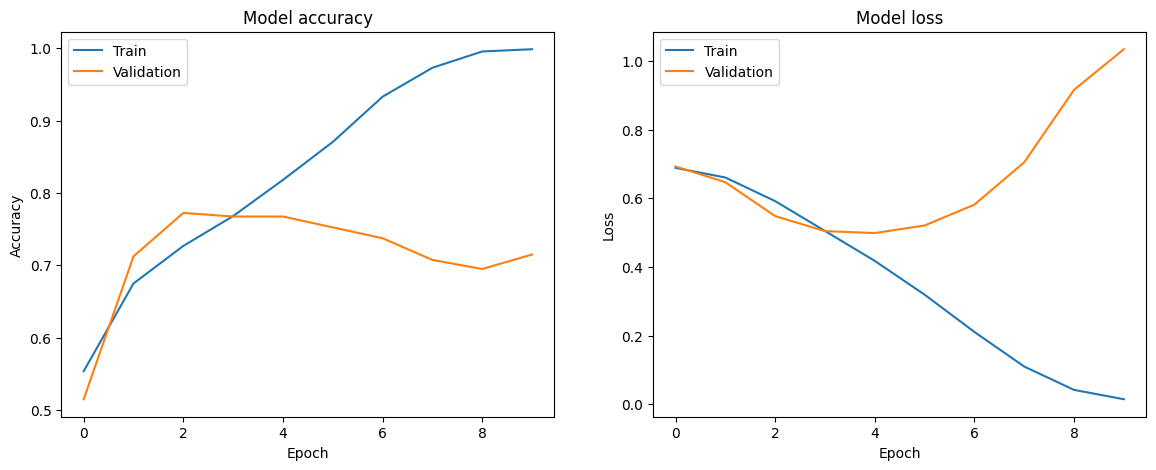

In [ ]:
plot_history(results.history)

# **Early stopping**

In [ ]:
# RESNET
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg')

In [ ]:
# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (21, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)
conv_lstm_output = BatchNormalization()(conv_lstm_output)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)
conv_lstm_output2 = BatchNormalization()(conv_lstm_output2)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 21, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_8 (TimeDi  (None, 21, 7, 7, 2048)       2358771   ['input_18[0][0]']            
 stributed)                                               2                                       
                                                                                                  
 conv_lstm2d_16 (ConvLSTM2D  (None, 21, 7, 7, 256)        2123468   ['time_distributed_8[0][0]']  
 )                                                        8                                       
                                                                                           

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'model_checkpoint2.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/10
200/200 [==============================] - 156s 567ms/step - loss: 0.6303 - accuracy: 0.6431 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 2/10
200/200 [==============================] - 104s 521ms/step - loss: 0.4218 - accuracy: 0.8200 - val_loss: 0.6293 - val_accuracy: 0.6350
Epoch 3/10
200/200 [==============================] - 104s 522ms/step - loss: 0.2783 - accuracy: 0.9025 - val_loss: 0.5293 - val_accuracy: 0.7275
Epoch 4/10
200/200 [==============================] - 104s 520ms/step - loss: 0.1651 - accuracy: 0.9538 - val_loss: 0.6542 - val_accuracy: 0.7150
Epoch 5/10
200/200 [==============================] - 104s 523ms/step - loss: 0.0822 - accuracy: 0.9825 - val_loss: 0.8536 - val_accuracy: 0.7250
Epoch 6/10
200/200 [==============================] - 104s 522ms/step - loss: 0.0296 - accuracy: 0.9956 - val_loss: 1.0956 - val_accuracy: 0.7375


In [ ]:
model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 8s 155ms/step - loss: 0.5293 - accuracy: 0.7275


{'loss': 0.5293319821357727, 'accuracy': 0.7275000214576721}

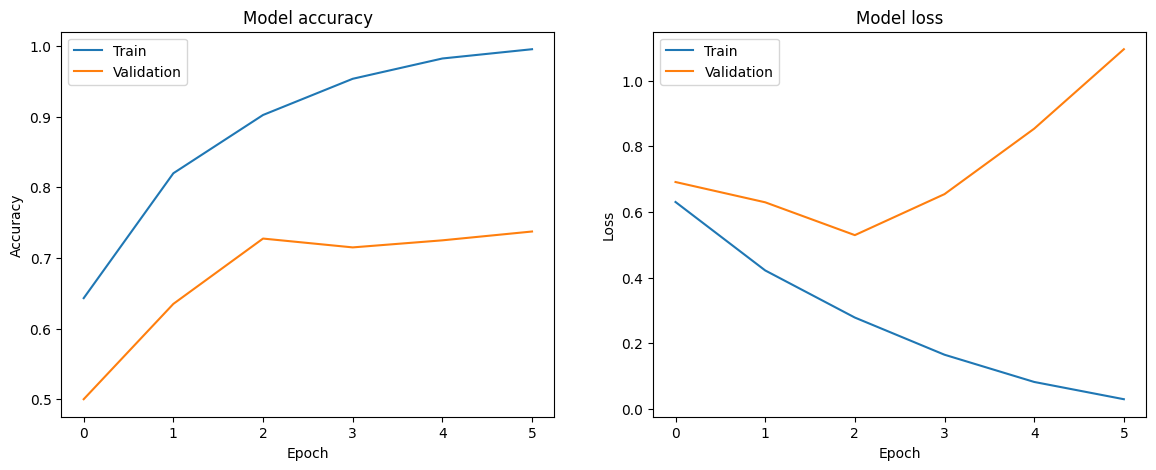

In [ ]:
plot_history(results.history)

In [ ]:
pretrained_model = None

In [ ]:
frame ,label = next(iter(train_ds))

print(frame.shape)
print(label.shape)

(8, 21, 224, 224, 3)
(8,)


# **Freeze Resnet**

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg', weights='imagenet')
pretrained_model.trainable = False

In [ ]:
# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (21, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)
conv_lstm_output = BatchNormalization()(conv_lstm_output)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)
conv_lstm_output2 = BatchNormalization()(conv_lstm_output2)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 21, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_11 (TimeD  (None, 21, 7, 7, 2048)       2358771   ['input_26[0][0]']            
 istributed)                                              2                                       
                                                                                                  
 conv_lstm2d_22 (ConvLSTM2D  (None, 21, 7, 7, 256)        2123468   ['time_distributed_11[0][0]'] 
 )                                                        8                                       
                                                                                           

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'model_checkpoint2.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/10
200/200 [==============================] - 68s 287ms/step - loss: 0.6643 - accuracy: 0.5994 - val_loss: 0.6873 - val_accuracy: 0.5125
Epoch 2/10
200/200 [==============================] - 54s 270ms/step - loss: 0.6186 - accuracy: 0.6450 - val_loss: 0.6589 - val_accuracy: 0.6475
Epoch 3/10
200/200 [==============================] - 54s 271ms/step - loss: 0.5895 - accuracy: 0.6831 - val_loss: 0.6094 - val_accuracy: 0.6775
Epoch 4/10
200/200 [==============================] - 54s 270ms/step - loss: 0.5633 - accuracy: 0.7125 - val_loss: 0.5814 - val_accuracy: 0.6750
Epoch 5/10
200/200 [==============================] - 55s 275ms/step - loss: 0.5385 - accuracy: 0.7369 - val_loss: 0.5775 - val_accuracy: 0.6800
Epoch 6/10
200/200 [==============================] - 54s 269ms/step - loss: 0.5142 - accuracy: 0.7606 - val_loss: 0.5758 - val_accuracy: 0.6650
Epoch 7/10
200/200 [==============================] - 53s 267ms/step - loss: 0.4898 - accuracy: 0.7887 - val_loss: 0.5769 - val_ac

In [ ]:
model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 8s 154ms/step - loss: 0.5758 - accuracy: 0.6650


{'loss': 0.5757536888122559, 'accuracy': 0.6650000214576721}

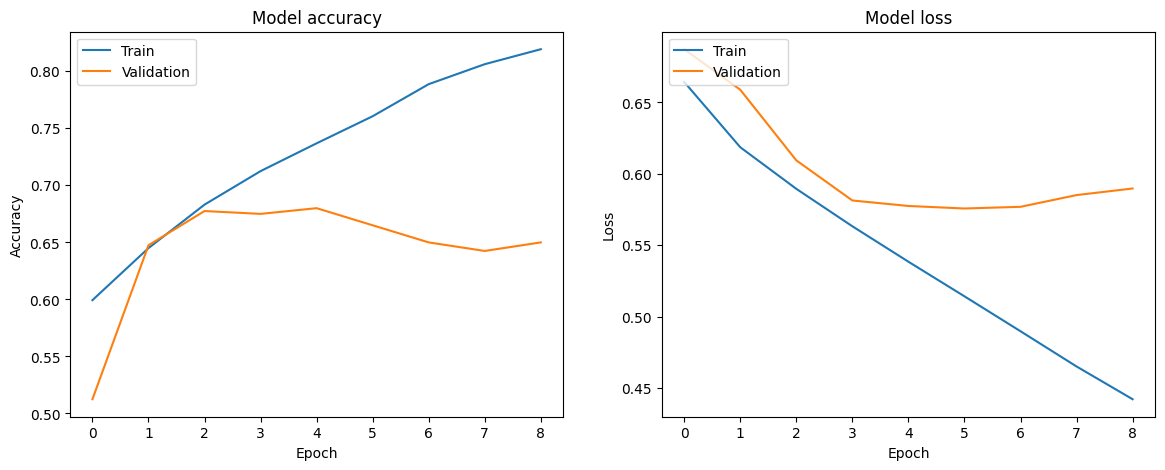

In [ ]:
plot_history(results.history)

# **tambah batch normalization**

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg', weights='imagenet')

# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (21, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)
conv_lstm_output = BatchNormalization()(conv_lstm_output)

mhsa_output = MultiHeadAttention(num_heads=1, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)
conv_lstm_output2 = BatchNormalization()(conv_lstm_output2)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 21, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_12 (TimeD  (None, 21, 7, 7, 2048)       2358771   ['input_29[0][0]']            
 istributed)                                              2                                       
                                                                                                  
 conv_lstm2d_24 (ConvLSTM2D  (None, 21, 7, 7, 256)        2123468   ['time_distributed_12[0][0]'] 
 )                                                        8                                       
                                                                                           

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'model_checkpoint2.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/10
200/200 [==============================] - 144s 532ms/step - loss: 0.6273 - accuracy: 0.6438 - val_loss: 0.6894 - val_accuracy: 0.5875
Epoch 2/10
200/200 [==============================] - 103s 514ms/step - loss: 0.4095 - accuracy: 0.8150 - val_loss: 0.6642 - val_accuracy: 0.5650
Epoch 3/10
200/200 [==============================] - 103s 513ms/step - loss: 0.2570 - accuracy: 0.9094 - val_loss: 0.5198 - val_accuracy: 0.7125
Epoch 4/10
200/200 [==============================] - 102s 512ms/step - loss: 0.1523 - accuracy: 0.9569 - val_loss: 0.6038 - val_accuracy: 0.7125
Epoch 5/10
200/200 [==============================] - 103s 516ms/step - loss: 0.0828 - accuracy: 0.9800 - val_loss: 0.7162 - val_accuracy: 0.7225
Epoch 6/10
200/200 [==============================] - 103s 514ms/step - loss: 0.0400 - accuracy: 0.9962 - val_loss: 0.8590 - val_accuracy: 0.7075


In [ ]:
model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 7s 148ms/step - loss: 0.5198 - accuracy: 0.7125


{'loss': 0.5198412537574768, 'accuracy': 0.7124999761581421}

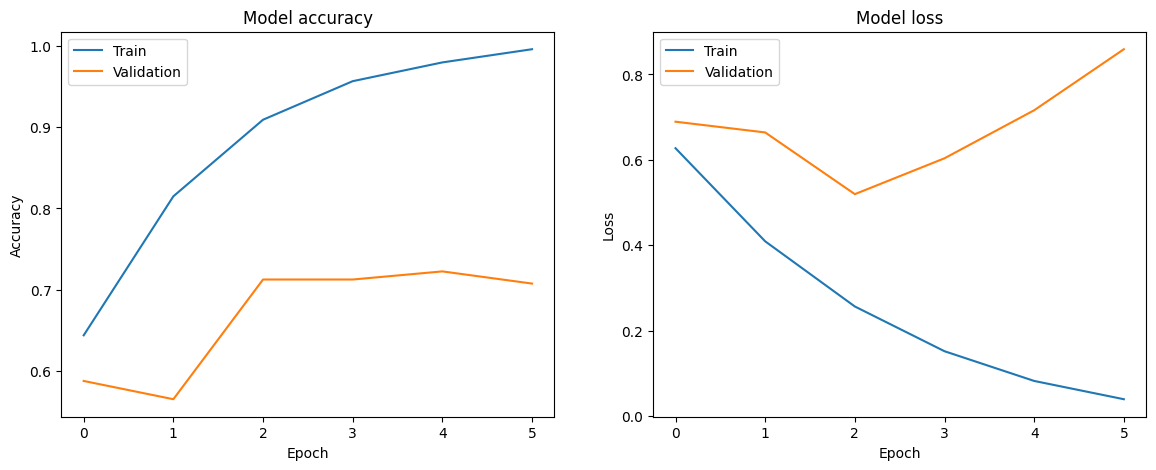

In [ ]:
plot_history(results.history)

# **Coba tambah Dropout**

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg', weights='imagenet')

# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (21, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)
conv_lstm_output = BatchNormalization()(conv_lstm_output)
conv_lstm_output = Dropout(0.5)(conv_lstm_output)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)
conv_lstm_output2 = BatchNormalization()(conv_lstm_output2)
conv_lstm_output2 = Dropout(0.5)(conv_lstm_output2)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 21, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed_16 (TimeD  (None, 21, 7, 7, 2048)       2358771   ['input_37[0][0]']            
 istributed)                                              2                                       
                                                                                                  
 conv_lstm2d_32 (ConvLSTM2D  (None, 21, 7, 7, 256)        2123468   ['time_distributed_16[0][0]'] 
 )                                                        8                                       
                                                                                           

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'model_checkpoint2.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/10
200/200 [==============================] - 145s 543ms/step - loss: 0.6255 - accuracy: 0.6444 - val_loss: 0.6936 - val_accuracy: 0.5150 - lr: 1.0000e-06
Epoch 2/10
200/200 [==============================] - 105s 525ms/step - loss: 0.4550 - accuracy: 0.7844 - val_loss: 0.6555 - val_accuracy: 0.6625 - lr: 1.0000e-06
Epoch 3/10
200/200 [==============================] - 105s 525ms/step - loss: 0.3033 - accuracy: 0.8794 - val_loss: 0.5618 - val_accuracy: 0.7325 - lr: 1.0000e-06
Epoch 4/10
200/200 [==============================] - 105s 525ms/step - loss: 0.1741 - accuracy: 0.9506 - val_loss: 0.5546 - val_accuracy: 0.7350 - lr: 1.0000e-06
Epoch 5/10
200/200 [==============================] - 105s 528ms/step - loss: 0.0819 - accuracy: 0.9900 - val_loss: 0.6227 - val_accuracy: 0.7225 - lr: 1.0000e-06
Epoch 6/10
200/200 [==============================] - 105s 523ms/step - loss: 0.0331 - accuracy: 0.9987 - val_loss: 0.6597 - val_accuracy: 0.7225 - lr: 1.0000e-06
Epoch 7/10
200/200 [==

In [ ]:
model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 8s 155ms/step - loss: 0.5546 - accuracy: 0.7350


{'loss': 0.5545545220375061, 'accuracy': 0.7350000143051147}

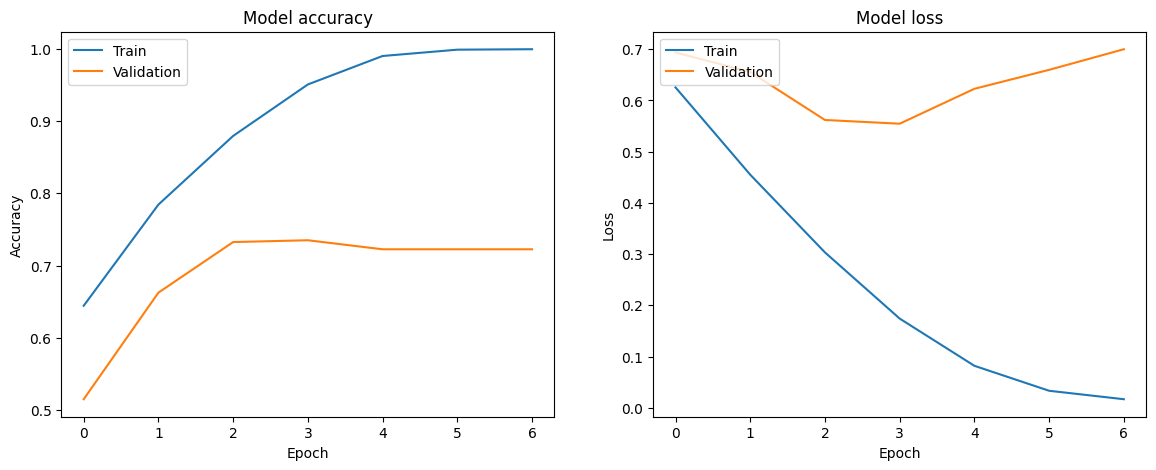

In [ ]:
plot_history(results.history)